In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from fbprophet import Prophet


%matplotlib inline

In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving PJME_hourly.csv to PJME_hourly.csv
User uploaded file "PJME_hourly.csv" with length 4070265 bytes


In [30]:
df=pd.read_csv("PJME_hourly.csv",index_col=[0],parse_dates=[0])
df.columns=["y"]
df.head()

,y
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


# **Visualisation**

<Figure size 144000x72000 with 0 Axes>

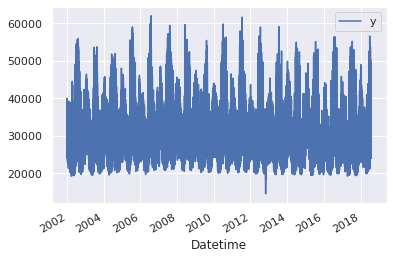

<Figure size 144000x72000 with 0 Axes>

In [101]:
df.plot()
plt.figure(figsize=(2000,1000))

In [0]:
daily_df = df.resample('D').apply(sum)

In [33]:
weekly_df = df.resample('W').apply(sum)
weekly_df.head()

,y
Datetime,
2002-01-06,4632079.0
2002-01-13,5289881.0
2002-01-20,5284084.0
2002-01-27,5063777.0
2002-02-03,4905010.0


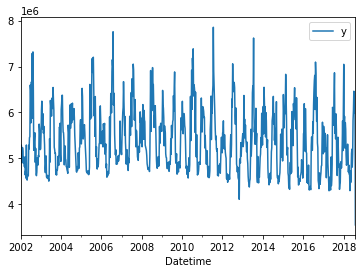

In [34]:
weekly_df.plot()


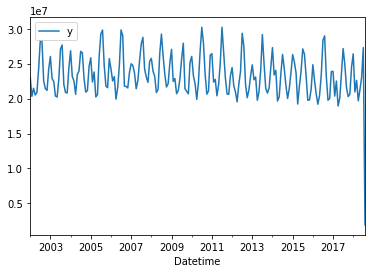

In [35]:
monthly_df = df.resample('M').apply(sum)
monthly_df.plot()

#seasonality is present

In [36]:
daily_df.shape

(6059, 1)

## **Forecasting**

In [0]:
import logging
logging.getLogger().setLevel(logging.ERROR)

In [38]:
w = weekly_df.reset_index()
w.columns = ['ds', 'y']
w.head(n=3)

,ds,y
0,2002-01-06,4632079.0
1,2002-01-13,5289881.0
2,2002-01-20,5284084.0


In [0]:
predictions=150
train_df=w[:-predictions]


In [40]:
model=Prophet()
model.fit(train_df);


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
future = model.make_future_dataframe(periods=predictions,freq="W")
future.tail(n=3)

,ds
863,2018-07-22
864,2018-07-29
865,2018-08-05


In [42]:
forecast=model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
861,2018-07-08,5.269168e+06,5.596799e+06,6.507879e+06,5.240004e+06,5.297119e+06,7.912726e+05,7.912726e+05,7.912726e+05,7.912726e+05,7.912726e+05,7.912726e+05,0.0,0.0,0.0,6.060441e+06
862,2018-07-15,5.268839e+06,5.797174e+06,6.677658e+06,5.239297e+06,5.297214e+06,1.000159e+06,1.000159e+06,1.000159e+06,1.000159e+06,1.000159e+06,1.000159e+06,0.0,0.0,0.0,6.268998e+06
863,2018-07-22,5.268510e+06,5.981137e+06,6.836495e+06,5.238576e+06,5.297163e+06,1.130955e+06,1.130955e+06,1.130955e+06,1.130955e+06,1.130955e+06,1.130955e+06,0.0,0.0,0.0,6.399465e+06
864,2018-07-29,5.268180e+06,5.917094e+06,6.844312e+06,5.237850e+06,5.297061e+06,1.117748e+06,1.117748e+06,1.117748e+06,1.117748e+06,1.117748e+06,1.117748e+06,0.0,0.0,0.0,6.385928e+06
865,2018-08-05,5.267851e+06,5.822968e+06,6.712763e+06,5.237129e+06,5.297022e+06,9.955149e+05,9.955149e+05,9.955149e+05,9.955149e+05,9.955149e+05,9.955149e+05,0.0,0.0,0.0,6.263366e+06


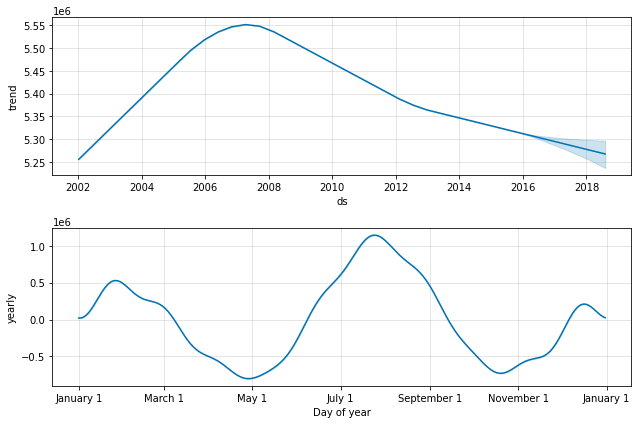

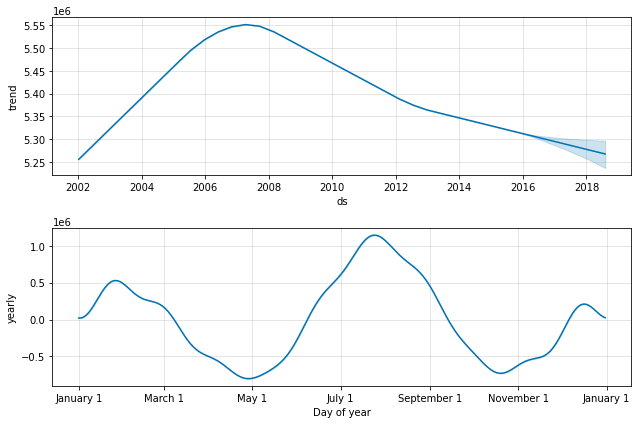

In [43]:
model.plot_components(forecast)

# **Forecast Evaluation**

In [44]:
def comparison_df(historical,forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

cmp_df=comparison_df(w,forecast)
cmp_df.tail(5)


,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-07-08,6.060441e+06,5.596799e+06,6.507879e+06,6461277.0
2018-07-15,6.268998e+06,5.797174e+06,6.677658e+06,6118566.0
2018-07-22,6.399465e+06,5.981137e+06,6.836495e+06,5982832.0
2018-07-29,6.385928e+06,5.917094e+06,6.844312e+06,6145746.0
2018-08-05,6.263366e+06,5.822968e+06,6.712763e+06,3547174.0


In [45]:
def calculate_forecast_errors(df, prediction_size):

    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

for err_name, err_value in calculate_forecast_errors(cmp_df, predictions).items():
    print(err_name, err_value)

MAPE 6.501847538363011
MAE 328705.2244982355


In [0]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [48]:
mean_absolute_error(y_true=cmp_df["y"],
                   y_pred=cmp_df["yhat"])

272346.0310358087

In [47]:
np.sqrt(mean_squared_error(cmp_df["y"],cmp_df["yhat"]))

367969.0713543283

In [49]:
 def mean_absolute_percentage_error(y_true, y_pred): 
   
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=cmp_df["y"],
                   y_pred=cmp_df['yhat'])

4.983101543504413

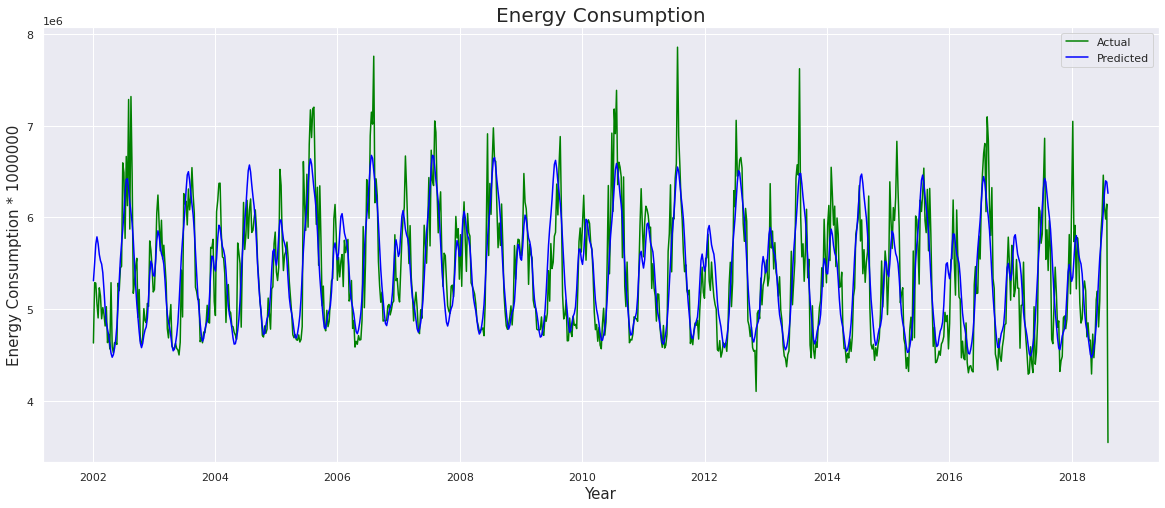

In [98]:

plt.figure(figsize=(20,8))
orig = plt.plot(cmp_df["y"], color='green',label='Actual' )
pred = plt.plot(cmp_df["yhat"], color='blue', label='Predicted')
plt.xlabel("Year",fontsize=15)
plt.ylabel("Energy Consumption * 1000000",fontsize=15)
plt.title('Energy Consumption', fontsize=20)
plt.legend()
plt.show(block=False)

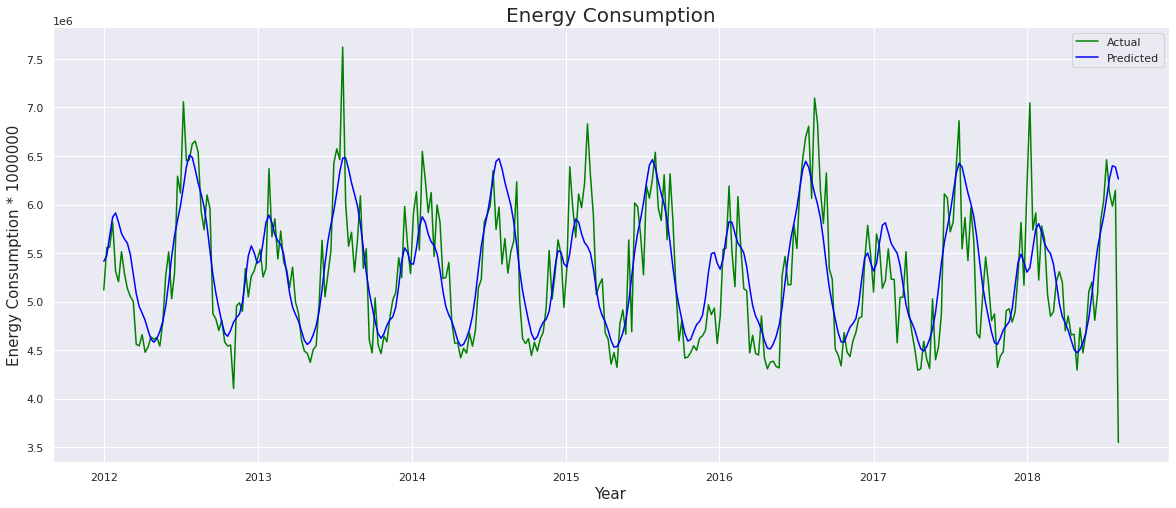

In [99]:
plt.figure(figsize=(20,8))
orig = plt.plot(cmp_df["2012-01-01":]["y"], color='green',label='Actual' )
pred = plt.plot(cmp_df["2012-01-01":]["yhat"], color='blue', label='Predicted')
plt.xlabel("Year",fontsize=15)
plt.ylabel("Energy Consumption * 1000000",fontsize=15)
plt.title('Energy Consumption', fontsize=20)
plt.legend()
plt.show(block=False)